In [1]:
# imports
from PIL import Image
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
# import time
import random
import lap
import os

from scipy.optimize import linear_sum_assignment

import torch
import torch.nn as nn

device = torch.device("cuda:0")

import warnings
warnings.filterwarnings('ignore')

# notebook settings
np.set_printoptions(edgeitems=11,infstr='inf', linewidth=150, nanstr='nan', precision=3, suppress=True, threshold=20, formatter=None)
torch.set_printoptions(precision=2, threshold=None, edgeitems=10, linewidth=150, profile=None, sci_mode=None)
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

### Utility for plotting and image generation

In [2]:
''' Plots any given number of images'''
def plot_grid(*images, figsize=6, fignumber="Filter", titles=None, occurences=False):
    num_plots = len(images)
    
    plt.close(fignumber)
    fig = plt.figure(figsize=(figsize*int(min(num_plots, 5)), figsize*int(max(num_plots//5, 1))), num=fignumber)

    for i, grid in enumerate(images):
        
        size = grid.shape
        
        if size[-1] == 1:
            if occurences:
                cmap=None
            else:
                cmap="gray"
        else:
            cmap=None
        
        if len(size) == 3:
            ax = fig.add_subplot(((num_plots - 1) // 5) + 1, min(int(num_plots % 5) + (int(num_plots // 5) * 5), 5), i+1)
            img = grid.reshape(*size)
            ax.imshow(np.squeeze(img), cmap=cmap, vmin=0)
            ax.set_xticks([])
            ax.set_yticks([])
             
        if titles is not None:
            ax.set_title(titles[i], fontsize=figsize*3)
    
    plt.show()

In [3]:
''' Generates feature vectors from small thumbnail images '''
def create_vectors_from_thumbnails(image_files, thumb_size=4):
    
    n_images = len(image_files)   
    feature_vectors = np.zeros((n_images, thumb_size*thumb_size*3))

    for i in range(n_images):
        file = image_files[i]
        im = Image.open(file)
        im.thumbnail((thumb_size, thumb_size), Image.Resampling.BOX)
        pixels = np.array(im) / 255
        pixels = pixels.reshape((thumb_size * thumb_size * 3))
        feature_vectors[i] = pixels
            
    return feature_vectors

In [4]:
def set_global_seed(seed: int) -> None:
    """
    Sets random seed into PyTorch, TensorFlow, Numpy and Random.
    Args:
        seed: random seed
    """
    try:
        import torch
    except ImportError:
        pass
    else:
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    try:
        import tensorflow as tf
    except ImportError:
        pass
    else:
        if parse(tf.__version__) >= Version("2.0.0"):
            tf.random.set_seed(seed)
        elif parse(tf.__version__) <= Version("1.13.2"):
            tf.set_random_seed(seed)
        else:
            tf.compat.v1.set_random_seed(seed)
    random.seed(seed)
    np.random.seed(seed)

## Load images 

In [5]:
set_folder = "./data/signs/"    # use web, kitchen or signs

from pathlib import Path
def list_all_image_paths(images_path):
    return sorted([str(f) for f in Path(images_path).rglob('*.*') if (("jpeg" in str(f).lower()) | ("jpg" in str(f).lower()) | ("png" in str(f).lower())) & ("._" not in str(f).lower()) & (".txt" not in str(f).lower())])

image_files_orig = list_all_image_paths(set_folder)

# use the feature vectors from the paper
vectors_orig = np.array(list(map(lambda f: np.load(os.path.join(os.path.dirname(f), "vectors", os.path.basename(f).split(".")[0]+".npy")), image_files_orig))).astype(np.float32)
# comment the line above and uncomment the line below to use thumbnail vectors for other images (with 4x4x3 = 48 dimensions)
# vectors_orig = create_vectors_from_thumbnails(image_files_orig, thumb_size=6).astype(np.float32)


In [6]:
def create_collage(sorted_1d_filepaths, n_images_per_side, pixels_per_image=32):
    
    reshaped_files = np.array(sorted_1d_filepaths).reshape((n_images_per_side, n_images_per_side))

    X = np.zeros((pixels_per_image*n_images_per_side, pixels_per_image*n_images_per_side, 3))

    for i in range(n_images_per_side):
        for j in range(n_images_per_side):

            file = reshaped_files[i, j]
            im = Image.open(file)
            im.thumbnail((pixels_per_image, pixels_per_image), Image.Resampling.LANCZOS)
            # im.thumbnail((pixels_per_image, pixels_per_image), Image.ANTIALIAS)
            pixels = np.array(im) / 255

            X[i*pixels_per_image:(i+1)*pixels_per_image, j*pixels_per_image:(j+1)*pixels_per_image] = pixels
            
    return X

In [7]:
def pretty_print(**args):
    for key in args.keys():
        print(key, end=': ')
        if isinstance(args[key], int):
            print('%4d' % args[key], end=' ')
        elif isinstance(args[key], torch.Tensor):
            args[key] = np.round(args[key].detach().cpu().numpy(), 3)
            print('%5.3f' % args[key], end=' ')
        elif isinstance(args[key], str):
            print('%s' % args[key], end=' ')
        elif isinstance(args[key], float):
            print('%5.3f' % args[key], end=' ')
    print()

## Distance Preservation Quality (DPQ)

In [8]:
def squared_l2_distance(q, p):
    
    ps = torch.sum(p * p, axis = 1, keepdim=True)
    qs = torch.sum(q * q, axis = 1, keepdim=True)
    p_q_transpose = torch.matmul(p, q.transpose(0, 1))

    squared_dists = ps - 2 * p_q_transpose + qs.transpose(0,1)
    return squared_dists 

In [9]:
''' Converts a given gridshape to a grid index matrix
    and calculates the squared spatial distances '''

def compute_spatial_distances_for_grid(grid_shape, wrap):
    if wrap:
        return compute_spatial_distances_for_grid_wrapped(grid_shape)
    else:
        return compute_spatial_distances_for_grid_non_wrapped(grid_shape)


def compute_spatial_distances_for_grid_wrapped(grid_shape):
    n_x = grid_shape[0]
    n_y = grid_shape[1]

    wrap1 = [[0, 0], [0, 0], [0, 0], [0, n_y], [0, n_y], [n_x, 0], [n_x, 0], [n_x, n_y]]
    wrap2 = [[0, n_y], [n_x, 0], [n_x, n_y], [0, 0], [n_x, 0], [0, 0], [0, n_y], [0, 0]]

    # create 2D position matrix with tuples, i.e. [(0,0), (0,1)...(H-1, W-1)]
    a, b = np.indices(grid_shape)
    mat = np.concatenate([np.expand_dims(a, -1), np.expand_dims(b, -1)], axis=-1)
    mat_flat = mat.reshape((-1, 2))

    # use this 2D matrix to calculate spatial distances between on positions on the grid
    d = squared_l2_distance(mat_flat, mat_flat)
    for i in range(8):
        # look for smaller distances with wrapped coordinates
        d_i = squared_l2_distance(mat_flat + wrap1[i], mat_flat + wrap2[i])
        d = np.minimum(d, d_i)

    return d


def compute_spatial_distances_for_grid_non_wrapped(grid_shape):
    # create 2D position matrix with tuples, i.e. [(0,0), (0,1)...(H-1, W-1)]
    a, b = torch.tensor(np.indices(grid_shape))
    a, b = a.type(torch.FloatTensor), b.type(torch.FloatTensor)
    mat = torch.cat([a[:, :, None], b[:, :, None]], axis=-1)
    mat_flat = mat.view((-1, 2))

    # use this 2D matrix to calculate spatial distances between on positions on the grid
    d = squared_l2_distance(mat_flat, mat_flat)
    return d
    

In [10]:
def sort_hddists_by_2d_dists_fast(hd_dists, ld_dists, device):
    hd_dists = hd_dists.type(torch.FloatTensor).to(device)
    max_hd_dist = torch.max(hd_dists) * 1.0001

    ld_hd_dists = (hd_dists/max_hd_dist + ld_dists).to(device)   # add the normed HD distances (0 .. 0.999) to the 2D integer distances
    ld_hd_dists = torch.sort(ld_hd_dists)[0]    # then a normal sorting of the rows can be used

    sorted_HD_D = torch.fmod(ld_hd_dists, 1) * max_hd_dist

    return sorted_HD_D
    

In [11]:
''' computes the Distance Preservation Gain delta DP_k(S) '''
def get_distance_preservation_gain(sorted_d_mat, d_mean, device):
    # range of numbers [1, K], with K = N-1
    nums = torch.arange(1, len(sorted_d_mat)).to(device)

    # compute cumulative sum of neighbor distance values for all rows, shape = (N, K)
    cumsum = torch.cumsum(sorted_d_mat[:, 1:], axis=1)

    # compute average of neighbor distance values for all rows, shape = (N, K)
    d_k = cumsum / nums

    # compute average of all rows for each k, shape = (K, )
    d_k = d_k.mean(axis=0)

    # compute Distance Preservation Gain and set negative values to 0, shape = (K, )
    # d_k = torch.maximum((d_mean - d_k) / d_mean, torch.tensor0)
    d_k = torch.clip((d_mean - d_k) / d_mean, 0, 1)
    return d_k

In [12]:
''' computes the Distance Preservation Quality DPQ_p(S) '''
def dpq(sorted_X, device, p=2, wrap=False):
    
    # setup of required variables
    grid_shape = sorted_X.shape[:-1]
    dim = sorted_X.shape[-1]
    N = np.prod(grid_shape)

    # compute matrix of euclidean distances in the high dimensional space
    dists_HD = torch.cdist(sorted_X.reshape(-1, dim), sorted_X.reshape(-1, dim), p=2)

    # sort HD distance matrix rows in acsending order (first value is always 0 zero now)
    sorted_D = torch.sort(dists_HD, -1)[0]

    # compute the expected value of the HD distance matrix
    mean_D = torch.mean(sorted_D[:, 1:])

    # compute spatial distance matrix for each position on the 2D grid (squared for integer dists)
    dists_spatial = compute_spatial_distances_for_grid(grid_shape, wrap).to(device)

    # sort rows of HD distances by the values of spatial distances
    sorted_HD_by_2D = sort_hddists_by_2d_dists_fast(dists_HD, dists_spatial, device)
    
    # get delta DP_k values
    delta_DP_k_2D = get_distance_preservation_gain(sorted_HD_by_2D, mean_D, device)
    delta_DP_k_HD = get_distance_preservation_gain(sorted_D, mean_D, device)

    # compute p norm of DP_k values
    normed_delta_D_2D_k = torch.linalg.norm(delta_DP_k_2D, ord=p)
    normed_delta_D_HD_k = torch.linalg.norm(delta_DP_k_HD, ord=p)

    # DPQ(s) is the ratio between the two normed DP_k values
    DPQ = normed_delta_D_2D_k / normed_delta_D_HD_k

    return DPQ

##  Loss Functions

In [13]:
def dist_matrix_loss_func(x_shuffled, x_sorted, p_dist_matrix):
    # distance matrix of the original (shuffled) data and of the shuffled (permuted) matrix
    dist_x_sorted = torch.cdist(x_sorted, x_sorted) ** p_dist_matrix
    dist_x_shuffled = torch.cdist(x_shuffled, x_shuffled) ** p_dist_matrix

    # doubly sorted distance matrices
    dist_x_shuffled_sort = torch.sort(torch.sort(dist_x_shuffled, 0)[0], 1)[0]
    dist_x_sorted_sort = torch.sort(torch.sort(dist_x_sorted, 0)[0], 1)[0]

    mean_dist_x_shuffled = torch.mean(dist_x_shuffled_sort)
    
    loss_distmatrix = (torch.mean(torch.abs(dist_x_shuffled_sort - dist_x_sorted_sort)) / mean_dist_x_shuffled) 

    return loss_distmatrix

In [14]:
def neighbor_loss_func(x_shuffled, x_sorted, k, p_dist_matrix=2):
    
    n = k * k

    dist_x_shuffled = torch.cdist(x_shuffled, x_shuffled, p=2) ** p_dist_matrix
    dist_x_sorted = torch.cdist(x_sorted, x_sorted, p=2) ** p_dist_matrix
    
    mean_dist_x_shuffled = dist_x_shuffled.mean()
    mean_dist_x_sorted = dist_x_sorted.mean()
    
    dist_hor = torch.diag(dist_x_sorted, diagonal=1)
    ind = torch.arange(n - 1)
    bool_index = (ind + 1) % k != 0
    dist_hor = dist_hor[bool_index]
    dist_hor_mean = torch.mean(dist_hor)

    dist_ver = torch.diag(dist_x_sorted, diagonal=k)
    dist_ver_mean = torch.mean(dist_ver)

    dist_neighbors = (0.5 * dist_hor_mean + 0.5 * dist_ver_mean) / mean_dist_x_shuffled  # mean distance horizontal and vertical

    return dist_neighbors

In [15]:
def constraint_loss(perm):
    constraintPenalty = torch.mean((torch.sum(perm, dim=0) - 1) ** 2) + torch.mean((torch.sum(perm, dim=1) - 1) ** 2)
    return constraintPenalty

## Sorting Network

In [16]:
class Gumbel_Sinkhorn_Network(torch.nn.Module):
    def __init__(self, n, n_iter):
        super(Gumbel_Sinkhorn_Network, self).__init__()
        self.n = n
        self.n_iter = n_iter
        self.W = torch.nn.Parameter(torch.rand((n*n)), requires_grad=True)

    def forward(self, tau=1, noise_factor=0):
        x = self.W
        x = x.reshape(self.n, self.n)  # reshape for sinkhorn operation

        P_hat = gumbel_sinkhorn(x, tau, self.n_iter, noise_factor)

        P = torch.zeros_like(P_hat) 
        P.scatter_(-1, P_hat.topk(1, -1)[1], value=1)
        P_hat_hard = (P - P_hat).detach() + P_hat

        return P_hat, P_hat_hard
    
def gumbel_sinkhorn(log_alpha: torch.Tensor, tau: float = 1.0, n_iter: int = 20, noise_factor: float = 0) -> (torch.Tensor,):
    uniform_noise = torch.rand_like(log_alpha)
    gumbel_noise = -torch.log(-torch.log(uniform_noise + 1e-20) + 1e-20)
    log_alpha = log_alpha + noise_factor * gumbel_noise

    sampled_perm_mat = log_sinkhorn_norm(log_alpha / tau, n_iter)
    return sampled_perm_mat

def log_sinkhorn_norm(log_alpha: torch.Tensor, n_iter: int = 20) -> (torch.Tensor,):
    for _ in range(n_iter):
        log_alpha = log_alpha - torch.logsumexp(log_alpha, -2, keepdim=True)
        log_alpha = log_alpha - torch.logsumexp(log_alpha, -1, keepdim=True)

    return log_alpha.exp()

## Learning sorted arrangements

In [17]:
# Parameters
dpq_p = 16           # power of the DPQ calculation

seed = 0  
iterations = 5000
learning_rate = 0.03 
n_iter = 10          # sinkhorn iterations
tau = 1              
noise_factor = 0.1   # factor for the gumbel noise 0 .. 1 (0.1)
p_dist = 2           # power of the distances for the loss functions 

ny = nx = int(np.sqrt(len(image_files_orig)))
n = nx * ny

# shuffle the images and vectors in random order
image_files = image_files_orig.copy()
vectors = vectors_orig.copy()
np.random.seed(seed)
np.random.shuffle(image_files)
np.random.seed(seed)
np.random.shuffle(vectors)

x_orig = torch.from_numpy(vectors)

In [18]:
set_global_seed(seed)

x_shuffled = x_orig.to(device)

net = Gumbel_Sinkhorn_Network(n, n_iter=n_iter).to(device) # n*n parameters

optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

for iteration in range(iterations+1):
    optimizer.zero_grad()

    alpha = iteration / iterations

    perm_soft, perm_hard = net(tau, noise_factor)
    
    x_sorted_soft = torch.matmul(perm_soft, x_shuffled)
    x_sorted_hard = torch.matmul(perm_hard, x_shuffled)
    
    loss_dist_neighbors = neighbor_loss_func(x_shuffled, x_sorted_soft, nx, p_dist)  
    loss_dist_matrix = dist_matrix_loss_func(x_shuffled, x_sorted_soft, p_dist)    
    loss_constrain = constraint_loss(perm_soft)
    
    loss = 0
    loss += loss_dist_neighbors
    loss += 10*alpha * loss_dist_matrix
    loss += 100*loss_constrain
    
    ind = torch.argmax(perm_hard, -1)
    num_duplicates = int(n - torch.unique(ind).shape[0])
    
    end = iteration == iterations or num_duplicates == 0

    if iteration % 100 == 0 or end:
        dist = torch.cdist(x_sorted_soft, x_shuffled, p=p_dist)
        _, ind = linear_sum_assignment(dist.detach().cpu().numpy())
        x_sorted_soft = x_sorted_soft.view(ny, nx, -1)
        x_sorted_hard = x_sorted_hard.view(ny, nx, -1)
        x_sorted_las = x_shuffled[ind].view(ny, nx, -1)
        
        dpq_S = dpq(x_sorted_soft, p=dpq_p, device=device)
        dpq_H = dpq(x_sorted_hard, p=dpq_p, device=device)
        dpq_L = dpq(x_sorted_las,  p=dpq_p, device=device)
        dpq_str = f"soft:{dpq_S:.3f}      hard:{dpq_H:.3f}      LSA:{dpq_L:.3f}"

        pretty_print(
            it=iteration,
            L=loss,
            dist_nb=loss_dist_neighbors,
            L_dm=loss_dist_matrix,
            L_c=loss_constrain,
            D=num_duplicates,
            DPQ_S=dpq_S, DPQ_H=dpq_H, DPQ_L=dpq_L)

    if end:
        break
        
    loss.backward()
    optimizer.step()


it:    0 L: 0.001 dist_nb: 0.001 L_dm: 0.999 L_c: 0.000 D:   55 DPQ_S: 0.467 DPQ_H: 0.240 DPQ_L: 0.408 
it:  100 L: 0.185 dist_nb: 0.002 L_dm: 0.915 L_c: 0.000 D:   61 DPQ_S: 0.927 DPQ_H: 0.686 DPQ_L: 0.796 
it:  200 L: 0.153 dist_nb: 0.049 L_dm: 0.259 L_c: 0.000 D:   51 DPQ_S: 0.948 DPQ_H: 0.908 DPQ_L: 0.901 
it:  300 L: 0.179 dist_nb: 0.074 L_dm: 0.175 L_c: 0.000 D:   41 DPQ_S: 0.964 DPQ_H: 0.951 DPQ_L: 0.914 
it:  400 L: 0.202 dist_nb: 0.097 L_dm: 0.131 L_c: 0.000 D:   31 DPQ_S: 0.962 DPQ_H: 0.957 DPQ_L: 0.927 
it:  500 L: 0.221 dist_nb: 0.122 L_dm: 0.097 L_c: 0.000 D:   13 DPQ_S: 0.960 DPQ_H: 0.940 DPQ_L: 0.930 
it:  600 L: 0.231 dist_nb: 0.155 L_dm: 0.061 L_c: 0.000 D:    5 DPQ_S: 0.954 DPQ_H: 0.935 DPQ_L: 0.929 
it:  700 L: 0.231 dist_nb: 0.197 L_dm: 0.023 L_c: 0.000 D:    0 DPQ_S: 0.942 DPQ_H: 0.930 DPQ_L: 0.930 


In [19]:
X = create_collage(image_files, nx)
sorted_files = np.array(image_files)[ind]
collage = create_collage(sorted_files, nx)
#plot_grid(X, collage, figsize=6, titles=["Random Arrangement", f"sorted {dpq_H.detach().cpu().numpy():.3}"])

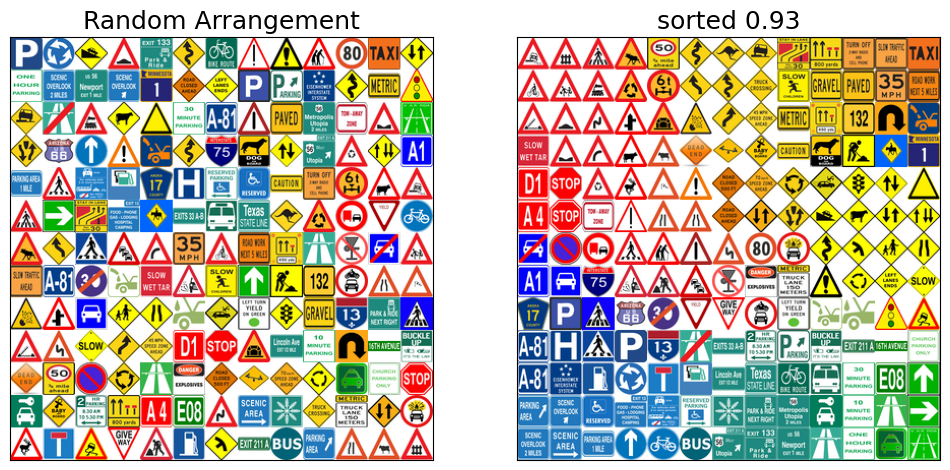

In [20]:
X = create_collage(image_files, nx)
sorted_files = np.array(image_files)[ind]
collage = create_collage(sorted_files, nx)
plot_grid(X, collage, figsize=6, titles=["Random Arrangement", f"sorted {dpq_H.detach().cpu().numpy():.3}"])